# Bibliotecas

In [ ]:
# instalação da biblioteca dask, que permite trabalhar melhor com grandes bases de dados
!pip install "dask[complete]" 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
# https://docs.dask.org/en/stable/ - documentação DASK
import dask.dataframe as dd
import random
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from datetime import date
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
from sklearn.manifold import TSNE

In [ ]:
# montando o drive no Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Análise Exploratória dos Dados (feita com 2 arquivos)

In [ ]:
# # efetuando a leitura de file_events com dask (perceba que é possível concatenar na própria função)
# parquet_file_events = "/content/drive/MyDrive/Dados Next/sampleOficina/events"
# file_events = dd.read_parquet(parquet_file_events+"/*.parquet")

In [ ]:
# # após concatenados os arquivos de eventos, vamos verificar algumas informações sobre o arquivo em si
# file_events.info(memory_usage="deep")

In [ ]:
# # efetuando a leitura de file_users com dask
# parquet_file_user = "/content/drive/MyDrive/Dados Next/sampleOficina/steps"
# file_user = dd.read_parquet(parquet_file_user+"/*.parquet")

In [ ]:
# # após concatenados os arquivos de usuários, vamos verificar algumas informações sobre o arquivo em si
# file_user.info(memory_usage="deep")

Agora, com os dados em mãos, devemos investigar ambas as base de dados com o objetivo de encontrar conclusões (breves insights), possíveis problemas (com base na estatística, principalmente) e também converter os dados em um formato visual, para que padrões, características e relacionamentos possam ser visualizados

Além disso, nosso problema se trata de um **problema de churn**, porém, nossa base de dados ainda não contém o dado que indica se um cliente efetuou churn ou não. Devemos então definir uma maneira de identificar o churn ou não de um cliente.

Devemos investigar as bases de dados com o objetivo de encontrar atributos que, relacionados, informem se o cliente ainda usa ativamente o aplicativo ou não.

Nessa fase de Análise Exploratória dos dados, algumas atividades são sugeridas:

* Análise Atributo a atributo
* Análisar os Tipos dos Atributos
* selecionar atributos que achar relevante
  * se possível, propor uma conversão de tipos para aquele atributo     
*   Valores com frequência acima da expectativa?
*   atributos possuem uma quantidade considerável de valores nulos?
    *    selecionar e entender
*   Dados contraditórios
* Estatísticas básicas (média, mediana, moda, distribuição normal, etc)
* Ranqueamento e ordenação (algum atributo faz sentido estar ordenado? ranqueado?)
* Tabulações
* Produção de gráficos
* Detecção de outliers ("pontos fora da curva")

## file_events

**file_events** com 214 linhas e 55 colunas, contém informações do APP em si e do aparelho celular que o APP está instalado

In [ ]:
file_events.head() # mostra as 5 primeiras linhas do data frame

NameError: ignored

In [ ]:
file_events.columns # mostra as colunas do data frame

In [ ]:
# função que mostra os valores e quantas vezes se repetem, por atributo (coluna), de um data frame
# obs: esta função tem se mostrado ineficiente trabalhando com a base de dados completa, pois o tempo de execução está muito alto
# devemos direcionar nossa análise, com o objetivo de reduzir o tempo de execução
def valores_atributos(df):
  for coluna in df.columns:
    #OBSERVAÇÃO GABRIEL: ao invés de fazer com todos os arquivos, outra possibilidade é fazer uma estimativa dos valores.
    # dessa forma: df[coluna].value_counts(frac=0.1).compute()
    # assim só vai usar 10% dos dados. uma vez que os dados que usamos já são uma amostra, podemos estimar os valores unicos para todos os arquivos
    # principalmente para colunas categoricas
    print(df[coluna].value_counts().compute(),"\n\n")  # atributos separados por 2 quebras de linha

In [ ]:
valores_atributos(file_events) # verificando atributos do data frame 'file_events'

# obs: está ineficiente usar esta função, pois o tempo está muito longo

In [ ]:
file_events['OPERATING_SYSTEM'].value_counts().compute()

**Análise atributo a atributo file_events:**

- O APP só possui um host, que no caso é br.com.bradesco.next

- HOST_APP_VERSION: alguns usuários ainda usam versões antigas do APP, VERIFICAR ESTATÍSTICAS, churn pode estar associado ao mal funcionamento do aplicativo em versões antigas.
  - O aplicativo não permite a utilização de uma versão antiga por muito tempo, logo se o usuário ficar em uma versão muito antiga por muito tempo pode indicar churn.

- Todos os dispositivos são ANDROID

- OS_VERSION: muitos usuários usam a maior versão dentre as listadas, mas alguns ainda usam versões antigas do SO, VERIFICAR ESTATÍSTICAS, o churn pode estar associado a má compatibilidade com sistemas android antigos.

- Temos algumas informações mais relacionadas ao aparelho celular do que do APP em si, como: 
    - NFC_ADAPTER (adaptador NFC presente oun não), 
    - NFC_ENABLED (NFC ligado ou não), 
    - BLUETOOTH_ENABLED, 
    - ROAMING_ENABLED, 
    - DATA_MOBILE_ENABLED (dados móveis ligados ou não), 
    - BATTERY_CHARGE_PERCENT (porcentagem da bateria no momento da captação do dado), 
    - NETWORK_OPERATOR (operadora de celular), 
    - NETWORK_TECHNOLOGY (tecnologia de rede utilizada pelo aparelho), 
    - LATITUDE e LONGITUDE, 
    - LOCATION_ACCURACY

- DURATION indica a quantidade de segundos que o usuário usou o next (para aqueles que tem 'Data_Session' no atributo 'EVENT_TYPE', caso contrário, 'DURATION' será 0)

- START_DATE informa a data e hora do início do evento

- MEMORY_USAGE_PERCENT e CPU_USAGE_PERCENT apresentam valores estranhos, ambos como sendo '-1' do tipo Int64

- EVENT_TYPE: tipo do evento, pode ser **Data_Session**, ou seja, a pessoa abriu, usou e fechou o next e também pode ser **Summarized Data**, que corresponde a cada aplicativo instalado no celular. Cada linha com 'Summarized_Data' indica um app instalado no celular.

- NETWORK_TYPE apresenta valores inconsistentes, como WIFI e wifi, OFFLINE e offline

- Atributos incompreendidos: INSTALLATION_NUMBER, OPERATOR, LAC, APP_NAME, APP_PACKAGE, APP_TRAFFIC_RX_TOTAL, APP_TRAFFIC_TX_TOTAL, DURATION

## file_user

**file_user** com 271 linhas e 52 colunas, é bem semelhante ao **file_events**, porém com menos atributos, além de apresentar alguns novos atributos

In [ ]:
file_user.head()

In [ ]:
file_user.columns

In [ ]:
valores_atributos(file_user) # a mesma análise, porém como dataset 'file_user'

**Análise atributo a atributo file_user:**

- este banco de dados contém diversos atributos iguais ao anterior, porém tais atributos possuem uma variedade maior de valores, além de mais linhas (atual: 271 e anterior: 214), como:
INSTALLATION_NUMBER, HANDSET, SIGNAL_STRENGTH, CELL_ID, LOCATION_PROVIDER, LOCAL_TIME, NETWORK_TECHNOLOGY, NETWORK_OPERATOR, OPERATOR

- APP_USER_ID é o id do usuário, mas todos estão nulos (não está indicando nulo, porém todos os valores estão preenchidos por ' ')

- Todos os dispositivos também são android

- O Host ainda continua sendo somente 'br.com.bradesco.next'

- diferente do banco de dados anterior, este contém diversas versões para OS_VERSION, com uma distribuição aparentemente mais uniforme entre eles (fazer mesma análise do outro)

- diferente do banco de dados anterior, este também contém diversas versões para o APP (HOST_APP_VERSION,), porém a maioria ainda se encontra na versão mais recente (fazer a mesma análise do outro)

- Este contém a ALTITUDE

- EVENT_DATE contém a data original de coleta dos dados, enquanto EVENT_DATE_BR contém a mesma data, porém no Brasil

- NETWORK_TYPE desta vez está formatado corretamente

- SSID: identificação do aparelho do usuário

- IPv4 e IPv6 em 'IP' e endereço MAC 'MAC_ADDRESS'

- FINGERPRINT: algum acesso à digital cadastrada no aparelho

- LABEL: interessante, possui valores 'Login Recorrente' e 'Start' **Confirmar com Gabriel o que significa**

- INSTALLED_APPS está sem valores

- Atributos incompreendidos: algumas da outra base de dados e LIB_VERSION, ICCID, TYPE, BSSID, IS_ROOTED, IS_MOCK_LOCATION, IS_FROM_EMULATOR, oq significam atributos que iniciam-se com 'PREV_...'?

In [ ]:
file_user.info()

* Sabemos que as bases de dados ainda não informam se o cliente efetuou churn ou não, pois de fato não sabemos este dado.

* Devemos então investigar os atributos de modo que algum deles (ou uma combinação entre 2 ou mais atributos) nos conte este novo dado ('churn').

* Temos atributos que medem o tempo de alguma forma?

**OBSERVAÇÃO GABRIEL: como assim atributos que medem o tempo? sabemos o tempo de cada userstep ou event com base no relógio do celular do cliente**

* Temos por enquanto o atributo 'EVENT_TYPE' que indica se o usuário abriu, usou e fechou o next (Data_Session) e também pode indicar os aplicativos instalados no celular (Sumarized Data). Se for Data_Session, o evento é a abertura do app, caso contrário, o evento é captura um app do celular **Confirmar com Gabriel se a parte do Summarized_Data é isso mesmo e, ainda, perguntar se há alguma forma de identificar aquele app, pelo nome do pacote, por exemplo**
**OBSERVAÇÃO GABRIEL:  sim. é isso mesmo. vou fazer upload de um banco de dados que tem o nome do app, categoria, nome do pacote do app no drive. alem de numero de estrelas e instalações. esse dataset será muito util. o nome desse dataset é: apps.parquet. e está na pasta Dados Next**

Quando temos 'Data_Session', temos que 'DURATION' significa o tempo que o app ficou aberto, caso contrário informa o tempo em que foi reportado

In [ ]:
# verificando como EVENT_TYPE se comporta
file_events['EVENT_TYPE'].value_counts()

Podemos observar que a maioria esmagadora dos eventos gerados são Summarized_Data. Isso faz sentido, pois cada Summarized_Data corresponde a 1 app instalado no celular da pessoa.

* Conseguimos identificar esse app, por meio do pacote, por exemplo?

Para facilitar, podemos gerar algumas amostras que contenham dados com ambos os valores para 'EVENT_TYPE' para que possamos analisar separadamente.

In [ ]:
amostra = file_events.sample(10)
# pegamos uma amostra qualquer com o intuito de obter dados que sejam 'Summarized_Data e também 'Data_Session'

amostra[['EVENT_TYPE', 'DURATION']]

A amostra gerada anteriormente foi uma das melhores obtidas, pois possuem 2 'Data_Session'. Na maioria das execuções, só obtivemos 'Summarized_Data'. Se necessário, podemos gerar outra amostra futuramente.

Podemos comprovar o que foi dito pelo Gabriel. Objetos com valor 'Data_Session' para o atributo 'EVENT_TYPE' possuem valor diferente de 0 para o atributo 'DURATION', que indica a quantidade de segundos que o usuário permaneceu usando o APP.

Podemos então coletar todos esses objetos com 'Data_Session' e verificar se de fato possuem valores diferente de 0 para 'DURATION'.

In [ ]:
data_session = file_events[file_events['EVENT_TYPE'] == 'Data_Session']

data_session[['EVENT_TYPE', 'DURATION']] # visualização dos dados

In [ ]:
data_session['DURATION'] == 0 # expressão lógica que retorna TRUE ou FALSE para as linhas do banco de dados

Assim como mencionado, nenhum 'Data_Session' possui 'DURATION' igual a 0.

O que o 'Data_Session' pode nos informar? Que no dia da captação do evento, estes objetos listados anteriormente estavam usando o APP.

Sabemos que 'START_DATE' indica a data e hora do início do evento e também que este atributo não possui valores nulos (análise feita anteriormente), logo, todos os valores para 'EVENT_TYPE' possuem data de captação, seja ele 'Data_Session' ou 'Summarized_Data'

**OBSERVAÇÃO GABRIEL: pode não ter valores nulos, mas as vezes tem datas como "1970-01-01" **

Vale lembrar que para 'Data_Session' o atributo 'START_DATE' indica o horário de abertura do app

**OBSERVAÇÃO GABRIEL: "o horário de abertura do app" de acordo com o horário do celular da pessoa**

Vamos verificar no banco de dados com somente 'Data_Session' e depois na amostra

In [ ]:
data_session[['EVENT_TYPE', 'DURATION', 'START_DATE']] # dataset com somente 'Data_Session'

In [ ]:
amostra[['EVENT_TYPE', 'DURATION', 'START_DATE']]  # amostra

Sabemos a data de captação da base de dados? 

**OBSERVAÇÃO GABRIEL: os dados são captados de forma contínua. ou seja, não tem uma data específica. eles são do período de 01-01-2021 até 30-07-2021**


Podemos comparar a data de captação do banco de dados com a última data do último Data_Session de cada usuário.


**OBSERVAÇÃO GABRIEL: sim. isso é válido. mesmo com os dados sendo capturados de forma contínua. lembrando que o usuário tem até 30-07-2021 para acessar o next. caso contrário, ele pode ser churn. ou pode acessar depois de 30-07-2021 mas não temos como saber.**

Existe algum atributo que identifique o usuário de modo que possamos **agrupar os dados por usuário**? Pois sabemos que 2 linhas podem referenciar a um mesmo usuário, já que cada linha com 'Summarized_Data' pode referenciar um app diferente no celular da pessoa.

Sim! Segundo a documentação enviada pela Cinnecta, o atributo 'EXTERNAL_IDENTIFIER'  significa 'Campo utilizado pelo cliente para identificação de um usuário' ou ainda 'Identificador único do usuário gerado pelo cliente'

In [ ]:
# agrupando por EXTERNAL_IDENTIFIER
agrupado_por_usuario = file_events.groupby(['EXTERNAL_IDENTIFIER'])

agrupado_por_usuario[['EVENT_TYPE']].describe()

In [ ]:
agrupado_por_usuario[['DURATION']].describe()

In [ ]:
agrupado_por_usuario[['START_DATE']].describe()

## Próximos Passos

Com as análises atributo a atributo das bases de dados, podemos observar que alguns atributos necessitam de uma atenção maior, por diversas causas. São elas:

- verificar a correlação entre o uso de versões anteriores do APP com o churn (após definir o critério) (HOST_APP_VERSION)

- todos valores são iguais (Ex: OPERATING_SYSTEM)

- verificar a correlação entre o uso de versões android antigas com o churn (após definir o critério) (OS_VERSION)

- MEMORY_USAGE_PERCENT e CPU_USAGE_PERCENT ambos -1 do tipo Int64

- NETWORK_TYPE apresenta valores inconsistentes (maiúsculo e minúsculo)

- atributos nulos (Ex: INSTALLED_APPS)

- atributo EVENT_DATE em file_user é do tipo string, porém EVENT_DATE_BR é do tipo datetime64. Podemos então utilizar com maior recorrência EVENT_DATE_BR

Além disso, o que difere as base de dados são os atributos:

Em file_user: 'OS', em file_events: 'OPERATING_SYSTEM'

Atributos em file_events e não em file_user:

APP_TRAFFIC_RX_TOTAL', 'APP_THROUGHPUT_RX_MIN', 'APP_THROUGHPUT_RX_Q25', 'APP_THROUGHPUT_RX_Q50', 'APP_THROUGHPUT_RX_Q75', 'APP_THROUGHPUT_RX_MAX',  'APP_TRAFFIC_TX_TOTAL', 'APP_THROUGHPUT_TX_MIN', 'APP_THROUGHPUT_TX_Q25', 'APP_THROUGHPUT_TX_Q50', 'APP_THROUGHPUT_TX_Q75', 'APP_THROUGHPUT_TX_MAX, CLIENT_VERSION, DEVICE_ID, IMSI, API_VERSION, NFC_ADAPTER, NFC_ENABLED, BLUETOOTH_ENABLED, DATA_MOBILE_ENABLED, ROAMING_ENABLED, MEMORY_USAGE_PERCENT, CPU_USAGE_PERCENT, BATTERY_CHARGE_PERCENT, START_DATE, DURATION, EVENT_TYPE, LAC, APP_NAME, LOCAL_TIME_ZONE, OTHER_PARTY_MSISDN, SEND_TIME, SMS_MESSAGE, SMS_PHONE_NUMBER, SMS_TIME

Atributos em file_user e não em file_events:

LIB_VERSION, APP_USER_ID, ALTITUDE, EVENT_DATE, SAME_LOCATION_COUNT, SCREEN_ON_COUNT, ICCID, SSID, TYPE, BSSID,IP, MAC_ADDRESS, FINGERPRINT, LABEL, IS_ROOTED, IS_MOCK_LOCATION, IS_FROM_EMULATOR, INSTALLED_APPS, 'PREV_EVENT_DATE', 'PREV_LOCAL_TIME', 'PREV_LAC', 'PREV_LATITUDE', 'PREV_LONGITUDE', 'PREV_ALTITUDE', 'PREV_SIGNAL_STRENGTH', 'PREV_CELL_ID', 'PREV_LOCATION_ACCURACY', 'PREV_LOCATION_PROVIDER', 'PREV_LOCATION_COUNT', 'PREV_SCREEN_ON_COUNT', 'EVENT_DATE_BR'

Existe a necessidade de alterar algumas variáveis categóricas para numéricas

In [ ]:
file_events["NETWORK_TYPE"] # pode ser realizado a transformação para inteiro, além de tratar maiúsculos e minúsculos

Devemos verificar mais variáveis que possam ser tratadas de tal forma

In [ ]:
plt.hist(file_events["DURATION"])
plt.xlabel("Duração em segundos")
plt.ylabel("Frequência")
plt.plot()

In [ ]:
# Mean_Log_Session = file_events["DURATION"].mean() # Média de duração da sessão das pessoas que logaram no next em segundos
# Std_Log_Session = file_events["DURATION"].std()

Mean_Log_Session = agrupado_por_usuario['DURATION'].mean() # Média de duração da sessão dos usuários que logaram no next em segundos
Std_Log_Session = agrupado_por_usuario['DURATION'].std()  # desvio padrão do dado obtido anteriormente

print("Média de uso (em segundos) por usuário:\n", Mean_Log_Session,"\n\nDesvio padrão:\n", Std_Log_Session)

In [ ]:
most_recent_version = max(file_events['HOST_APP_VERSION'].values,key=str) # pegando o valor da versão mais recente do aplicativo
most_recent_version

In [ ]:
users_old_version = file_events[file_events['HOST_APP_VERSION'] != most_recent_version] # Analisando os usuário que não possuem versões atuais
users_old_version[['HOST_APP_VERSION','DURATION','EVENT_TYPE']].head(10)

In [ ]:
users_not_Summarized = users_old_version[users_old_version['EVENT_TYPE'] != 'Summarized_Data']
users_not_Summarized[['HOST_APP_VERSION','DURATION','EVENT_TYPE']]

Como podemos observar, houve apenas uma ocorrência de um usuário em uma versão antiga com o EVENT_TYPE igual a "Data_Session", o que pode nos ajudar a determinar se a versão antiga é determinante na caracterização de churn.


**OBSERVAÇÃO GABRIEL: houve apenas em uma ocorrência, mas em qual fração dos dados. uma ocorrência em 0.0001% dos dados ou uma ocorrência em 10% dos dados. isso é importante.**


Observação:

  - Se for possível determinar se uma pessoa atualizou o aplicativo ou não, isso pode ser útil para caracterizar o churn

In [ ]:
# verificando datas de coletas dos datasets
data_coleta_users = pd.to_datetime(file_user['EVENT_DATE_BR']).dt.date  #file_user
data_coleta_events = pd.to_datetime(file_events['START_DATE']).dt.date  #file_events
# o código acima converte o tipo datetime para date, pois só queremos verificar a ocorrência do dia e não do horário em si
#obs: datetime contém data e hora; date contém somente data

display(data_coleta_users.value_counts())
display(data_coleta_events.value_counts())

Os dados estão enviesados em relação às datas de coletas dos eventos, pois só tivemos coleta nos dias apresentados acima (3 dias distintos). Além disso, temos que pensar que pode acontecer do usuário ficar alguns dias sem acessar o banco por n motivos, logo, não podemos basear nossa análise em 3 dias somente.


**OBSERVAÇÃO GABRIEL: em três dias não, mas temos 7 meses de dados. aqui no drive não tem tudo. mas vou fazer upload já. pois eventualmente vamos lidar com toda a base de dados.**


Assim como o Gabriel havia dito, devemos concatenar as outras bases de dados nestas que já foram trabalhadas, para obter uma análise com maior riqueza, sendo mais abrangente e leal ao cenário que estamos trabalhando.

# Critério de Churn

## HOST_APP_VERSION

Como decidido em reunião, vamos fazer análises das versões do Next instaladas para cada usuário ao longo do tempo. E também acesso do next para cada usuário ao longo do tempo. 

Para depois comparar os insights obtidos com cada um dessas análises e decidir como vão ser as regras pra classificação de churn.

Lembrando que quanto mais simples de  entender melhor. Mas se tivermos uma justificativa boa podemos fazer alguma regra tipo: 
  - todos que ficaram sem atualizar 1 mês e ficaram sem entrar 1 semana são churners. Ou ficaram sem atualizar 1 semana e sem entrar 1 mês também são churners.

*   Analisar Tempo de Uso
*   Analisar Versão
*   Analisar Tipo de Evento
*   Analisar outros atributos (colunas) que você(s) acha que tem relação com churn relacionado à versão



Agora que vamos fazer a análise voltada para o critério de churn, primeiro precisar selecionar as colunas necessária do data frame para que possamos efetuar a análise.

Porém, fazer essa análise com todo o conjunto de dados pode ser inviável, devido ao tempo de processamento ser muito alto.

Vamos então pegar uma amostra aleatória dentre os arquivos e observar suas colunas.

In [ ]:
# caminho do drive
caminho_events = '/content/drive/MyDrive/Dados Next/sampleOficina/events'
# salva o nome dos arquivos em uma lista
lista_arquivos_events = glob.glob(caminho_events + "/*.parquet")
# coleta um elemento aleatório da lista
amostra_events = random.choice(lista_arquivos_events)

# amostra_events contém um arquivo de amostra do
amostra_events_db = pd.DataFrame(pd.read_parquet(amostra_events))
amostra_events_db.columns

Coluna versão: 'HOST_APP_VERSION'

Colunas que aparentemente tem algua relação com a versão do APP:
- CONFIG_VERSION (o que significa?)
- START_DATE (momento da captação dos dados)
- DURATION (duração do data_session)
- EVENT_TYPE (tipo do evento)
- EXTERNAL_IDENTIFIER (id do usuário daquela linha, lembrando que podemos ter mais de 1 linha para 1 usuário)
- INSTALLATION_NUMBER
- CLIENT_VERSION
- API_VERSION (não será incluído pois todos os valores são nulos)

In [ ]:
# efetuando a leitura de file_events com dask (perceba que é possível concatenar na própria função)
parquet_file_events = "/content/drive/MyDrive/Dados Next/sampleOficina/events"
file_events = dd.read_parquet(parquet_file_events+"/*.parquet", columns=['EXTERNAL_IDENTIFIER', 'HOST_APP_VERSION', 'INSTALLATION_NUMBER',
                                                                         'CLIENT_VERSION', 'CONFIG_VERSION',
                                                                         'START_DATE', 'DURATION', 'EVENT_TYPE'])

In [ ]:
file_events.head()

In [ ]:
file_events.compute().info()

In [ ]:
#convertendo START_DATE para datetime
file_events['START_DATE'] = dd.to_datetime(file_events['START_DATE'])

In [ ]:
# Convert to pandas dataframe - documentação compute: https://docs.dask.org/en/latest/generated/dask.dataframe.DataFrame.compute.html
# operações basicas podem ser usadas neste novo dataframe
file_events_pandas = file_events.compute()

In [ ]:
file_events_pandas.info()

### Verificando atributo 'CONFIG_VERSION'

A versão 1.7 é uma antiga versão (em termos de configuração interna) do Next?

Vamos verificar a ocorrência das versões 1.7 e 1.8 e ver se sobrepõem de acordo com o tempo (usuários diferentes usando versões diferentes em uma mesma data)

In [ ]:
file_events_next_17 = file_events_pandas[file_events_pandas['CONFIG_VERSION'] == '[new]Next_1.7']

file_events_next_17

In [ ]:
file_events_next_18 = file_events_pandas[file_events_pandas['CONFIG_VERSION'] == '[new]Next_1.8']

file_events_next_18

In [ ]:
file_events_next_17['START_DATE'].describe()

**Temos linhas com datas em 2023**

Temos que verificar estes dados inconsistentes

In [ ]:
file_events_next_18['START_DATE'].describe()

In [ ]:
dados_17 = file_events_next_17['START_DATE'].unique()
dados_18 = file_events_next_18['START_DATE'].unique()

In [ ]:
# verifica se alguma data com config version 1.7 também tem a ocorrência de config version 1.8
conta_datas_iguais = 0
for data in dados_17:
  if (data in dados_18): 
    conta_datas_iguais+=1
print("Existem", conta_datas_iguais, "datas iguais")  

Suposição: se de fato CONFIG_VERSION indica uma versão nas configurações do aplicativo, por se tratar de detalhes internos (e talvez bem delicados) da implementação, a atualização para a versão 1.8 pode ter sido obrigatória para todos os usuários. 

Porém, como verificado acima, datas de file_events_next_17 contém datas de file_events_next_18 e vice-versa, então, em um determinado tempo, usuários estavam usando as 2 versões.

Ainda não podemos descartar a hipótese, mas é um indício de que houve sobreposição de versões de acordo com tempo...
Ou talvez, não...

Sabemos que quando temos a ocorrência de um data_session, o usuário usou o aplicativo, então podemos verificar a mesma análise porém somente para linhas que contenham data_session em EVENT_TYPE

In [ ]:
data_session_17 = file_events_next_17[file_events_next_17['EVENT_TYPE'] == 'Data_Session']
data_session_18 = file_events_next_18[file_events_next_18['EVENT_TYPE'] == 'Data_Session']

In [ ]:
data_session_17['EVENT_TYPE'].value_counts()

In [ ]:
data_session_18['EVENT_TYPE'].value_counts()

In [ ]:
dados_17 = data_session_17['START_DATE'].unique()
dados_18 = data_session_18['START_DATE'].unique()

In [ ]:
# verifica se alguma data com config version 1.7 também tem a ocorrência de config version 1.8
conta_datas_iguais = 0
datas_iguais = []


for i in dados_17:
  if (i in dados_18): 
    datas_iguais.append(i)
    conta_datas_iguais+=1
print("Existem", conta_datas_iguais, "datas iguais")  

Mesmo filtrando pelo Data_Session, verificamos que usuários diferentes que abriram, usaram e fecharam o next, em um determinado tempo, estavam usando versões diferente

In [ ]:
datas_iguais

In [ ]:
for data in datas_iguais:
  display(file_events_pandas[file_events_pandas['START_DATE'] == data][['EXTERNAL_IDENTIFIER', 'HOST_APP_VERSION', 'EVENT_TYPE', 'START_DATE', 'CONFIG_VERSION']])

Queremos que config_version nos conte algo sobre a versão do aplicativo, mas até agora, não observamos nenhuma relação direta.

Temos usuários com 1.7 (CONFIG_VERSION) usandos versões (HOST_APP_VERSION) mais recentes que outros usuários 1.8 em alguns dias, enquanto em outros dias temos o inverso...

E inclusive, em 2021-06-05 13:39:30, 2 usuários de CONFIG_VERSION diferentes (1.7 e 1.8) possuíam a mesma versão (HOST_APP_VERSION)

In [ ]:
minimo_17_events = min(file_events_next_17['HOST_APP_VERSION'])
minimo_18_events = min(file_events_next_18['HOST_APP_VERSION'])

print(minimo_17_events,minimo_18_events)

In [ ]:
max_17_events = max(file_events_next_17['HOST_APP_VERSION'])
max_18_events = max(file_events_next_18['HOST_APP_VERSION'])

print(max_17_events,max_18_events)

Aqui podemos verificar que a mínima e máxima versão de configurações 1.7 e 1.8 são iguais, demonstrando mais ainda a sobreposição no tempo

In [ ]:
amostra17 = file_events_next_17['HOST_APP_VERSION'].sample(1000000)
amostra18 = file_events_next_18['HOST_APP_VERSION'].sample(1000000)
sortedVersion17 = sorted(amostra17)
sortedVersion18 = sorted(amostra18)
analise = pd.DataFrame()
analise['1.7'] = sortedVersion17
analise['1.8'] = sortedVersion18

In [ ]:
qt_bins_17 = len(analise['1.7'].value_counts())  # temos 42 versões diferentes para 1.7, podemos utilizar esta quantidade de bins no grafico

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=50)
analise['1.7'].hist(bins=qt_bins_17)
plt.xlabel("Versão do aplicativo")
plt.ylabel("Quantidade")
plt.yscale('log')
plt.show()

In [ ]:
qt_bins_18 = len(analise['1.8'].value_counts())  # temos 38 versões diferentes para 1.7, podemos utilizar esta quantidade de bins no grafico

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=50)
analise['1.8'].hist(bins=qt_bins_18)
plt.xlabel("Versão do aplicativo")
plt.ylabel("Quantidade")
plt.yscale('log')
plt.show()

** Comparando uma amostra de 1 milhão de valores das versões de configuração 1.7 e 1.8, podemos notar que na configuração 1.7 as versões do aplicativo se concentram em valores mais antigos de versão, enquanto que na configuração 1.8 as verões são mais atuais.**

Podemos ainda fazer um scatter plot e verificar a relação versão x tempo e ainda colorir config version 1.7 com uma cor diferente de config version 1.8 (cor dos pontos)

In [ ]:
# podemos pegar uma amostra de 500 mil linhas
dados_reduzidos = file_events_pandas[['START_DATE', 'HOST_APP_VERSION', 'CONFIG_VERSION', 'EVENT_TYPE']].sample(500000)

In [ ]:
fig = px.scatter(dados_reduzidos, x='START_DATE', y='HOST_APP_VERSION', color='CONFIG_VERSION')
fig.update_traces(marker = dict(size = 12, line = dict(width=2)), selector = dict(mode = 'markers'))
fig.update_layout(title = 'Versão do aplicativo X Tempo')
fig.update_xaxes(title = 'Data')
fig.update_yaxes(title = 'Versão do aplicativo')
fig.show()


Podemos remover o outlier de 2023 (somente desta análise) e perceber o novo gráfico

In [ ]:
indices = dados_reduzidos[dados_reduzidos['START_DATE'] == dados_reduzidos['START_DATE'].max()].index

In [ ]:
dados_reduzidos.drop(indices, inplace=True)

In [ ]:
fig = px.scatter(dados_reduzidos, x='START_DATE', y='HOST_APP_VERSION', color='CONFIG_VERSION')
fig.update_traces(marker = dict(size = 12, line = dict(width=2)), selector = dict(mode = 'markers'))
fig.update_layout(title = 'Versão do aplicativo X Tempo')
fig.update_xaxes(title = 'Data')
fig.update_yaxes(title = 'Versão do aplicativo')
fig.show()

Além disso, vamos selecionar somente Data_Session

In [ ]:
dados_reduzidos = dados_reduzidos[dados_reduzidos['EVENT_TYPE'] == 'Data_Session']

In [ ]:
fig = px.scatter(dados_reduzidos, x='START_DATE', y='HOST_APP_VERSION', color='CONFIG_VERSION')
fig.update_traces(marker = dict(size = 12, line = dict(width=2)), selector = dict(mode = 'markers'))
fig.update_layout(title = 'Versão do aplicativo X Tempo')
fig.update_xaxes(title = 'Data')
fig.update_yaxes(title = 'Versão do aplicativo')
fig.show()

Ainda percebemos a sobreposição de config versions de acordo com o tempo

Apesar de uma observação interessante:

*   CONFIG_VERSION 1.7 se concentra em valores mais antigos de HOST_APP_VERSION, enquanto que na CONFIG_VERSION 1.8 as versões são mais atuais para HOST_APP_VERSION

Segundo algumas análises feitas anteriormente, podemos dizer que não foi possível encontrar uma maneira como o atributo CONFIG_VERSION pudesse influenciar diretamente na decisão de churn voltada para a versão (HOST_APP_VERSION), ou seja, não foi possível entender, com auxílio do atributo CONFIG_VERSION, como o usuário deixou ou não de usar o next de acordo com o tempo (datas).

Inicialmente foi pensado que a atualização de 1.7 -> 1.8 seria obrigatória para todos os usuários que quisessem continuar usando o next, porém percebemos que existiram usuários com CONFIG_VERSION 1.7, usando inclusive versões mais antigas para HOST_APP_VERSION, usando o next no mesmo dia que um outro usuário com CONFIG_VERSION 1.8.



## EVENT_TYPE

**TAREFAS**

1- Plotar o último uso de cada usuário
- eixo x: intervalos de tempo
- eixo y: quantidade de usuários que acessaram por último nesta data
- max START_DATE para o groupby de EXTERNAL_IDENTIFIER

2- Criar coluna *TIPO_CHURNER* para o tempo sem usar (para cada usuário)
  - com certeza
  - talvez churner
  - infrequente
  - Obs: pegar em relação à última data

3- Analisar a frequência de uso do next para cada classe acima

4- Mostrar o churn de acordo com o tempo

5- Analisar frequência geográfica x Churn (qual cidade tem mais churn, etc)


In [ ]:
# caminho do drive
caminho_events = '/content/drive/MyDrive/Dados Next/datasession.parquet'
file_events = dd.read_parquet(caminho_events+"/*.parquet")

In [ ]:
file_events.columns

Index(['HOST_APP_PACKAGE', 'HOST_APP_VERSION', 'INSTALLATION_NUMBER',
       'CLIENT_VERSION', 'CONFIG_VERSION', 'DEVICE_ID', 'HANDSET',
       'OPERATING_SYSTEM', 'IMSI', 'OPERATOR', 'ADVERTISING_ID', 'OS_VERSION',
       'API_VERSION', 'NFC_ADAPTER', 'NFC_ENABLED', 'BLUETOOTH_ENABLED',
       'DATA_MOBILE_ENABLED', 'ROAMING_ENABLED', 'MEMORY_USAGE_PERCENT',
       'CPU_USAGE_PERCENT', 'BATTERY_CHARGE_PERCENT', 'START_DATE', 'DURATION',
       'EVENT_TYPE', 'NETWORK_OPERATOR', 'NETWORK_TECHNOLOGY', 'LAC',
       'CELL_ID', 'LATITUDE', 'LONGITUDE', 'LOCATION_ACCURACY',
       'SIGNAL_STRENGTH', 'NETWORK_TYPE', 'APP_NAME', 'APP_PACKAGE',
       'APP_TRAFFIC_RX_TOTAL', 'APP_THROUGHPUT_RX_MIN',
       'APP_THROUGHPUT_RX_Q25', 'APP_THROUGHPUT_RX_Q50',
       'APP_THROUGHPUT_RX_Q75', 'APP_THROUGHPUT_RX_MAX',
       'APP_TRAFFIC_TX_TOTAL', 'APP_THROUGHPUT_TX_MIN',
       'APP_THROUGHPUT_TX_Q25', 'APP_THROUGHPUT_TX_Q50',
       'APP_THROUGHPUT_TX_Q75', 'APP_THROUGHPUT_TX_MAX', 'EXTERNAL_IDENT

In [ ]:
# convertendo data para datetime
file_events['START_DATE'] = dd.to_datetime(file_events['START_DATE'])

file_events[['START_DATE']].info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 1 entries, START_DATE to START_DATE
dtypes: datetime64[ns](1)

In [ ]:
file_events[['LATITUDE']] = file_events[['LATITUDE']].astype(str)
file_events[['LONGITUDE']] = file_events[['LONGITUDE']].astype(str)

**EXTERNAL_IDENTIFIER**

Estavamos analisando 4396809 dados de 49271 usuários

Agora vamos analizar 5222693 dados de 73005 usuário

**EVENT_TYPE**

Nessa base de dados só temos eventos do tipo Data_Session

### Tarefa 1: Plotar o último uso de cada usuário

In [ ]:
id_data = file_events[['EXTERNAL_IDENTIFIER', 'START_DATE', 'LATITUDE', 'LONGITUDE', 'DURATION']]  # pegando somente colunas que interessem a tarefa

In [ ]:
id_data_pandas_total = id_data.compute()

In [ ]:
# usar o file_events no futuro -> buscar usar o dask
id_data_pandas_total['MES_ANO'] = pd.to_datetime(id_data_pandas_total['START_DATE'],format='%m/%Y').dt.to_period('m')
id_data_pandas_total

,EXTERNAL_IDENTIFIER,START_DATE,LATITUDE,LONGITUDE,DURATION,MES_ANO
0,THxsUmFOMe3V/fXYAb93mCcwcbRmOZMTqCLyuSfUyLPKHo...,2021-07-19 14:51:04,0.0,0.0,50,2021-07
1,+tB/6B0CxcnrYyGSex3HEtiN7RfrKwrfIsDrmjPe+2302W...,2021-07-27 20:57:39,-3.1181,-60.01228,117,2021-07
2,uKtmSSaFbmM3hGvzak3woGO1wMoacwac2RVA4+6GGE5BWP...,2021-07-17 22:52:04,-18.0084,-39.86181,53,2021-07
3,oI5TYcS39GkCX+iRM33FOXjr+alPCbQaneW+1IJGtNR6Ph...,2021-07-19 10:52:38,-5.86652,-45.97713,53,2021-07
4,Y+PyP5bGW1JYzTJVQ83ACucujRA9Ig8GjLuL1yuRLg4Po1...,2021-07-19 12:57:48,-5.5205,-38.27233,30,2021-07
...,...,...,...,...,...,...
82375,z3f0cxJCRRT4TizOuyY9Sm3nMhn8ioeT0WHtWg08lUHm+7...,2021-01-01 21:21:39,-23.33933,-46.03739,31,2021-01
82376,1VPmF4l8T44IY+/8Mj7RQh5EvUGO3YJgncBo6Rx09Q1nCB...,2021-01-05 01:02:48,-23.57813,-46.60455,167,2021-01
82377,dDORQPImd1FknMzF5lEzLbnZ45ANJiHFn21/oOPLB7+Hu9...,2021-03-17 10:01:06,-23.68092,-46.63357,104,2021-03
82378,4WgRqq4dcNqKaId67ceYKnxZF5HiRIkt7ttdzzKJ4+9wNm...,2021-04-08 14:15:46,-5.45212,-39.71688,56,2021-04


In [ ]:
id_data_pandas_total.describe()

,DURATION
count,5.222693e+06
mean,6.774975e+02
std,7.508577e+05
min,3.000000e+01
25%,4.300000e+01
50%,6.500000e+01
75%,1.040000e+02
max,1.623162e+09


Pegando uma amostra:

In [ ]:
id_data_pandas = id_data_pandas_total.sample(1000000)

In [ ]:
id_data_pandas.describe()

,DURATION
count,1.000000e+06
mean,2.154300e+02
std,1.122717e+05
min,3.000000e+01
25%,4.300000e+01
50%,6.500000e+01
75%,1.040000e+02
max,1.117395e+08


In [ ]:
id_data_pandas['EXTERNAL_IDENTIFIER'].value_counts()

HUYFLH26j4LZXV6SMsloYKQQVFr4enl3Wsad/bCVNZKKwfA8AWGY0FY3cyOlzfY/    395
YwCqzLPxsbJ9iNz5dknJjescDNaBcI5XUbwzRxtMro55iL02NxKVUX7ds+TZ2KdS    346
gZn1PyW/ZjMt+0yor4t/tdEeJkIYkILCTfeAtpwFmPEDRYxQCXz1ApMFoOT9girk    296
Icqj8c5popeM7CZiUIlJ4rbJpYqFosGy8Joaf6vSLwvOMDJsfI7meH3CXGc76ZH3    275
yzV/BSp57vwN09bwSLT/S1TN6/F8bVyrtflVijXfcW1kkktbncYsfnqcNmIYS4H0    260
                                                                   ... 
meEeSqNoZAKh7745G5QZK+VCinm4sVttKEGVv5lWKdApdlxmEYMoWkJru5C8LyDq      1
EXeV/YmbfVCYuI8fvfU3BaleqRtuiGiRNn0bvFRE2gqVkej/gSSHoPTLGdkUIS6h      1
iTcs45LKh2B4dYG6gaMrkQfcRDq/RxTWtXDhOKyTf2GEziK6CT5FeLGFW/HX0MhA      1
/kJhp0aAoHQI6TEO2nRC3GbZTY1weDsPMMfDIkqEXA44n6jFRROrQYyBoyOB7ZHn      1
NeyNfjEz9NQ1RYP1JZ/1OtD/8QmpEZVgbBsOZaPjcAdwh0XjtwrKI7EID7VwLIP0      1
Name: EXTERNAL_IDENTIFIER, Length: 65043, dtype: int64

In [ ]:
agrupado_usuario_pandas = id_data_pandas.groupby('EXTERNAL_IDENTIFIER')

In [ ]:
ultimo_acesso = agrupado_usuario_pandas['START_DATE'].max().reset_index()
ultimo_acesso['PRIMEIRO_ACESSO'] = agrupado_usuario_pandas['START_DATE'].min().reset_index()['START_DATE']

In [ ]:
ultimo_acesso

,EXTERNAL_IDENTIFIER,START_DATE,PRIMEIRO_ACESSO
0,++2OlFA8+GV6Ni9cvdGXGJtgW98rZO0BA2OwmMdbROBHOw...,2021-07-23 21:25:46,2021-05-08 04:37:11
1,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,2021-04-03 16:04:37,2021-02-14 17:56:16
2,++4s1WdfVHGtQTSaAIhvfS1IpnAaSfwBffh+GFQxaDFAPM...,2021-07-13 20:38:32,2020-12-21 21:29:42
3,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,2021-07-25 17:21:56,2021-06-27 13:10:10
4,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,2021-07-25 23:24:07,2021-07-03 06:53:19
...,...,...,...
65038,zzcjigMcKz77/2u0zOiMGkuPLf8siD/qGLYGIyTmcUYjaV...,2021-07-23 13:44:14,2021-04-08 23:20:12
65039,zzmnDdlPgqiOJPNizqS9KD7dpkwfBd0fUZQlHBq/cYRODA...,2021-04-06 17:58:36,2021-04-06 17:58:36
65040,zznkUaMd0qF0UPe/P4+scb2W24Q9ZLo3rhMFhQsy2aKtt1...,2021-07-01 18:36:37,2021-06-17 18:36:22
65041,zzrYxWPAITi9/jmgBs+cn8lYNe5UlnDA0pejrY67C8q7t3...,2021-07-30 18:34:47,2021-07-04 11:15:18


In [ ]:
ids_possiveis = ultimo_acesso['EXTERNAL_IDENTIFIER'].unique()

# mapeando possiveis 'EXTERNAL_IDENTIFIER' a um inteiro
id = dict() 

for i in range (len(ultimo_acesso)):
   id[ids_possiveis[i]] = i+1

#adicioanando coluna auxiliar
ultimo_acesso['ID_NUMERAL'] = ultimo_acesso['EXTERNAL_IDENTIFIER'].map(id)

In [ ]:
ultimo_acesso.rename(columns={'START_DATE': 'ULTIMO_ACESSO'}, inplace=True)

In [ ]:
ultimo_acesso['ULTIMO_ACESSO'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   65043
unique                  63849
top       2021-07-30 16:57:01
freq                        4
first     2020-08-11 18:23:22
last      2021-07-31 20:31:06
Name: ULTIMO_ACESSO, dtype: object

In [ ]:
ultimo_acesso['ULTIMO_ACESSO'].value_counts()

2021-07-30 16:57:01    4
2021-07-23 20:56:04    4
2021-07-28 21:35:40    3
2021-07-29 21:21:08    3
2021-07-29 19:19:42    3
                      ..
2021-07-15 11:08:46    1
2021-07-29 17:39:29    1
2021-07-21 10:30:26    1
2021-07-16 01:44:18    1
2021-07-29 00:22:41    1
Name: ULTIMO_ACESSO, Length: 63849, dtype: int64

In [ ]:
fig = px.scatter(ultimo_acesso, x='ULTIMO_ACESSO', y='ID_NUMERAL')
fig.update_traces(marker = dict(size = 12, line = dict(width=2)), selector = dict(mode = 'markers'))
fig.update_layout(title = 'Último Acesso de cada usuário')
fig.update_xaxes(title = 'Data')
fig.update_yaxes(title = 'ID Usuário')
fig.show()

In [ ]:
# podemos pegar uma amosrta para facilitar a visualização
amostra_ultimo_acesso_usuarios = ultimo_acesso.sample(100)

In [ ]:
fig = px.scatter(amostra_ultimo_acesso_usuarios, x='ULTIMO_ACESSO', y='ID_NUMERAL')
fig.update_traces(marker = dict(size = 12, line = dict(width=2)), selector = dict(mode = 'markers'))
fig.update_layout(title = 'Último Acesso de cada usuário')
fig.update_xaxes(title = 'Data')
fig.update_yaxes(title = 'ID Usuário')
fig.show()

O gráfico acima mostra o exato último acesso para cada id (eixo y - id aux Letícia)

Fizemos com 6000, 600, 250 e 100 amostras e todas apresentaram um comportamento semelhante

Portanto, foi mantida a de 100, por apresentar fácil visualização e ainda ser representativa (visualmente falando)

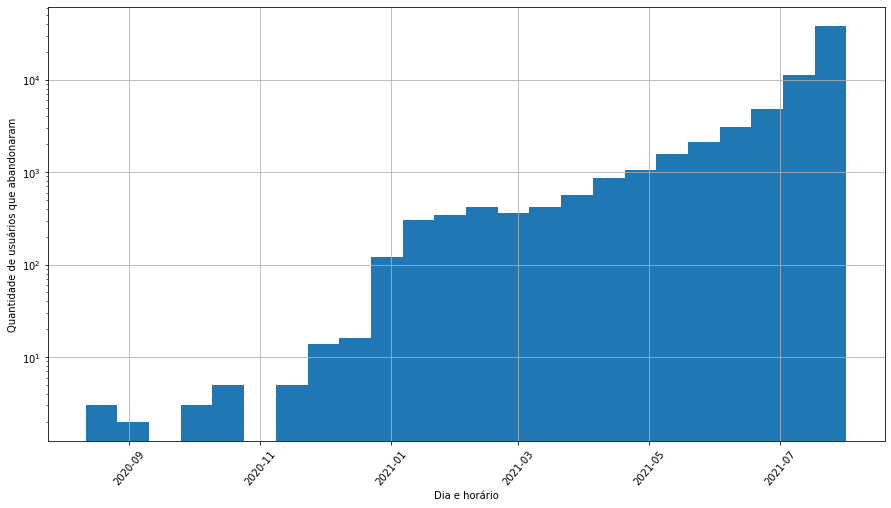

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=50)
ultimo_acesso['ULTIMO_ACESSO'].hist(bins=24)
plt.xlabel("Dia e horário")
plt.ylabel("Quantidade de usuários que abandonaram")
plt.yscale('log')
plt.show()

Observamos que fica inviável a análise com todos os dados, vamos pegar somente uma amostra

In [ ]:
amostra_ultimo_acesso = ultimo_acesso.sample(6000)  # pegamos uma amostra de 10% dos usuários

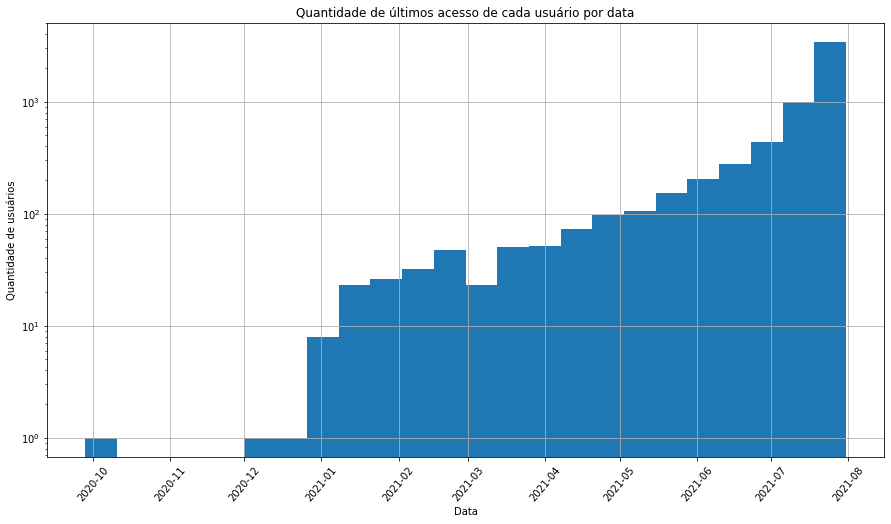

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=50)
amostra_ultimo_acesso['ULTIMO_ACESSO'].hist(bins=24)
plt.xlabel("Data")
plt.ylabel("Quantidade de usuários")
plt.title("Quantidade de últimos acesso de cada usuário por data")
plt.yscale('log')
plt.show()

10% dos usuários ainda nos mostraram comportamentos semelhantes no quesito visualização

Agora temos que obter os períodos signficativos para determinar as categorias de usuário: 

- com certeza
- talvez churner
- infrequente

Como olhar para os gráficos acima e determinar isso?

### Tarefa 2: Criar coluna *TIPO_CHURNER* para o tempo sem usar (para cada usuário)

#### Definindo data de comparação = última data de acesso

In [ ]:
maiorValor = ultimo_acesso['ULTIMO_ACESSO'].max()
maiorValor

Timestamp('2021-07-31 20:31:06')

#### Pegando os intervalos para determinar as categorias

In [ ]:
dataParametroChurn = str(maiorValor.day) + "/" + str(maiorValor.month-2) + "/" + str(maiorValor.year)
certezaChurn = pd.to_datetime(dataParametroChurn)
certezaChurn

Timestamp('2021-05-31 00:00:00')

In [ ]:
dataParametroChurn = str(maiorValor.day-1) + "/" + str(maiorValor.month-1) + "/" + str(maiorValor.year)
talvezChurn = pd.to_datetime(dataParametroChurn)
talvezChurn

Timestamp('2021-06-30 00:00:00')

In [ ]:
dataParametroChurn = str(maiorValor.day-7) + "/" + str(maiorValor.month) + "/" + str(maiorValor.year)
infrequente = pd.to_datetime(dataParametroChurn)
infrequente

Timestamp('2021-07-24 00:00:00')

In [ ]:
dataParametroChurn = str(maiorValor.day-6) + "/" + str(maiorValor.month) + "/" + str(maiorValor.year)
freq = pd.to_datetime(dataParametroChurn)
freq

Timestamp('2021-07-25 00:00:00')

In [ ]:
# alternativa
(pd.to_datetime('21/01/2001') - pd.to_timedelta('30 days')) > pd.to_datetime('21/01/2001')

False

#### Com os intervalos determinados, podemos aplicar as categorias a uma coluna

In [ ]:
bins = [ultimo_acesso['ULTIMO_ACESSO'].min(),certezaChurn,talvezChurn,infrequente,ultimo_acesso['ULTIMO_ACESSO'].max()]
names = ['CERTEZA_CHURN','TALVEZ_CHURN','INFREQUENTE','FREQUENTE']
ultimo_acesso['CAT_CHURN'] = pd.cut(ultimo_acesso['ULTIMO_ACESSO'], bins, labels=names)
ultimo_acesso['CAT_CHURN'].value_counts()

FREQUENTE        26033
INFREQUENTE      23930
CERTEZA_CHURN     7683
TALVEZ_CHURN      7396
Name: CAT_CHURN, dtype: int64

In [ ]:
ultimo_acesso[['CAT_CHURN','ULTIMO_ACESSO']].head(10)

,CAT_CHURN,ULTIMO_ACESSO
0,INFREQUENTE,2021-07-23 21:25:46
1,CERTEZA_CHURN,2021-04-03 16:04:37
2,INFREQUENTE,2021-07-13 20:38:32
3,FREQUENTE,2021-07-25 17:21:56
4,FREQUENTE,2021-07-25 23:24:07
5,CERTEZA_CHURN,2021-04-12 17:30:44
6,INFREQUENTE,2021-07-19 15:17:40
7,FREQUENTE,2021-07-29 15:11:39
8,FREQUENTE,2021-07-28 14:01:52
9,FREQUENTE,2021-07-26 01:23:11


#### Considerando o intervalo dos valores obtemos categorias diferente se definidas manualemte.

Por exemplo: 
 - INFREQUENTE	2021-07-10 22:42:17

Para que um usuário seja infrequente, ele tem que estar a 1 semana sem usar o aplicativo. Entretanto, para ele ser um possivel churn ele precisa estar a 1 mês sem usar o aplicativo. Dessa forma, os dados cujos valores estão entre 1 mês sem uso e até 1 semana sem uso são categorizados como infrequentes.

Essa idéia é aplicada aos demais valores.

### Tarefa 3: Analisar a frequência de uso do next para cada classe acima

In [ ]:
ultimo_acesso['CAT_CHURN'].value_counts()

FREQUENTE        26033
INFREQUENTE      23930
CERTEZA_CHURN     7683
TALVEZ_CHURN      7396
Name: CAT_CHURN, dtype: int64

In [ ]:
ultimo_acesso['MES'] = ultimo_acesso['ULTIMO_ACESSO'].dt.strftime('%m')

In [ ]:
freq = ultimo_acesso[ultimo_acesso['CAT_CHURN'] == 'FREQUENTE']
infreq = ultimo_acesso[ultimo_acesso['CAT_CHURN'] == 'INFREQUENTE']
churn = ultimo_acesso[ultimo_acesso['CAT_CHURN'] == 'CERTEZA_CHURN']
talvez = ultimo_acesso[ultimo_acesso['CAT_CHURN'] == 'TALVEZ_CHURN']

freq

,EXTERNAL_IDENTIFIER,ULTIMO_ACESSO,PRIMEIRO_ACESSO,ID_NUMERAL,CAT_CHURN,MES
3,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,2021-07-25 17:21:56,2021-06-27 13:10:10,4,FREQUENTE,07
4,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,2021-07-25 23:24:07,2021-07-03 06:53:19,5,FREQUENTE,07
7,++OmhTW6CDIIqNDFSbyHJscHu04m0rXRCDjKElglvdOOxZ...,2021-07-29 15:11:39,2021-07-29 15:06:49,8,FREQUENTE,07
8,++R9+bmn8WTs+gVDGElkVkZapdmGOkZrCWR3Srp8wGOAEa...,2021-07-28 14:01:52,2021-07-05 23:47:36,9,FREQUENTE,07
9,++SyHygfPA+YfHSBBg0ABJcBBrvo4Ft29ft2XE1/0urg1I...,2021-07-26 01:23:11,2021-01-02 16:09:16,10,FREQUENTE,07
...,...,...,...,...,...,...
65035,zzMfixlqx3Th9FBer4qPDzx6u8jHhKk66Yl1c/l80J4ydy...,2021-07-28 16:48:27,2021-03-16 11:58:42,65036,FREQUENTE,07
65036,zzQw3iqtieaDqCINniJLQI5wgCmgy0SnMcg9DmGtMiKSZy...,2021-07-29 23:01:40,2021-03-24 19:04:39,65037,FREQUENTE,07
65037,zzaMDz5nietF6jze9BlHjIuCD8bKWUMOWJB2XC22XYH5ad...,2021-07-30 19:57:33,2021-03-13 11:48:50,65038,FREQUENTE,07
65041,zzrYxWPAITi9/jmgBs+cn8lYNe5UlnDA0pejrY67C8q7t3...,2021-07-30 18:34:47,2021-07-04 11:15:18,65042,FREQUENTE,07


vamos verificar quantos meses há em cada base de dados para plotar corretamente o gráfico (bins)

In [ ]:
freq['MES'].value_counts()

07    26033
Name: MES, dtype: int64

In [ ]:
infreq['MES'].value_counts()

07    23434
06      496
Name: MES, dtype: int64

In [ ]:
churn['MES'].value_counts()

05    3361
04    1877
03     908
02     816
01     627
12      68
11      14
10       7
09       3
08       2
Name: MES, dtype: int64

In [ ]:
talvez['MES'].value_counts()

06    7200
05     196
Name: MES, dtype: int64

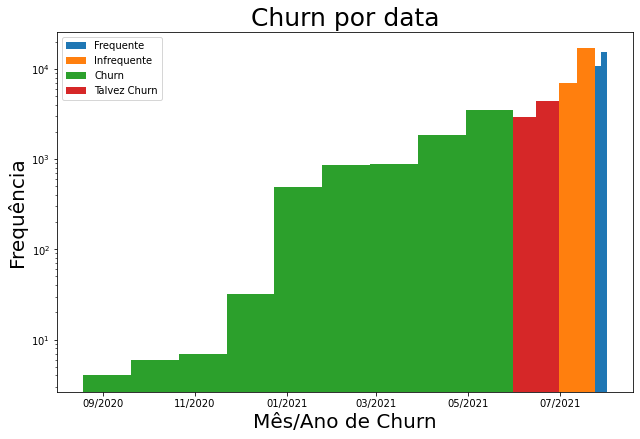

In [ ]:
formato_de_data = mdates.DateFormatter('%m/%Y')
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
plt.hist(freq['ULTIMO_ACESSO'], bins=2, label='Frequente')
plt.hist(infreq['ULTIMO_ACESSO'], bins=2, label='Infrequente')
plt.hist(churn['ULTIMO_ACESSO'], bins=9,label='Churn')
plt.hist(talvez['ULTIMO_ACESSO'], bins=2, label='Talvez Churn')
plt.legend(loc='upper left') 
eixo.set_title('Churn por data', fontsize=25)
eixo.set_ylabel('Frequência', fontsize=20)
eixo.set_xlabel('Mês/Ano de Churn', fontsize=20)
eixo.xaxis.set_major_formatter(formato_de_data)
plt.yscale('log')
plt.show()

#https://acervolima.com/histogramas-de-sobreposicao-com-matplotlib-em-python/

modelo de plot: https://media.istockphoto.com/vectors/multiple-bar-chart-colored-vector-multibar-histogram-vector-id1248250616

### Tarefa 4: Mostrar o churn de acordo com o tempo

In [ ]:
ultimo_acesso

,EXTERNAL_IDENTIFIER,ULTIMO_ACESSO,PRIMEIRO_ACESSO,ID_NUMERAL,CAT_CHURN,MES
0,++2OlFA8+GV6Ni9cvdGXGJtgW98rZO0BA2OwmMdbROBHOw...,2021-07-23 21:25:46,2021-05-08 04:37:11,1,INFREQUENTE,07
1,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,2021-04-03 16:04:37,2021-02-14 17:56:16,2,CERTEZA_CHURN,04
2,++4s1WdfVHGtQTSaAIhvfS1IpnAaSfwBffh+GFQxaDFAPM...,2021-07-13 20:38:32,2020-12-21 21:29:42,3,INFREQUENTE,07
3,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,2021-07-25 17:21:56,2021-06-27 13:10:10,4,FREQUENTE,07
4,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,2021-07-25 23:24:07,2021-07-03 06:53:19,5,FREQUENTE,07
...,...,...,...,...,...,...
65038,zzcjigMcKz77/2u0zOiMGkuPLf8siD/qGLYGIyTmcUYjaV...,2021-07-23 13:44:14,2021-04-08 23:20:12,65039,INFREQUENTE,07
65039,zzmnDdlPgqiOJPNizqS9KD7dpkwfBd0fUZQlHBq/cYRODA...,2021-04-06 17:58:36,2021-04-06 17:58:36,65040,CERTEZA_CHURN,04
65040,zznkUaMd0qF0UPe/P4+scb2W24Q9ZLo3rhMFhQsy2aKtt1...,2021-07-01 18:36:37,2021-06-17 18:36:22,65041,INFREQUENTE,07
65041,zzrYxWPAITi9/jmgBs+cn8lYNe5UlnDA0pejrY67C8q7t3...,2021-07-30 18:34:47,2021-07-04 11:15:18,65042,FREQUENTE,07


In [ ]:
ultimo_acesso['MES_ANO'] = pd.to_datetime(ultimo_acesso['ULTIMO_ACESSO'],format='%m/%Y').dt.to_period('m')
ultimo_acesso_churn = ultimo_acesso[ultimo_acesso['CAT_CHURN'] == 'CERTEZA_CHURN']
ultimo_acesso_churn

,EXTERNAL_IDENTIFIER,ULTIMO_ACESSO,PRIMEIRO_ACESSO,ID_NUMERAL,CAT_CHURN,MES,MES_ANO
1,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,2021-04-03 16:04:37,2021-02-14 17:56:16,2,CERTEZA_CHURN,04,2021-04
5,++IHcREkJhf3W116mvYMTHbfgERDe7cq4Rug0Ccjl7jCK3...,2021-04-12 17:30:44,2021-04-12 15:18:49,6,CERTEZA_CHURN,04,2021-04
18,+/GVAVTPZCcFrJNO2s3MzgVeLO0tVGqUX4MfwzTzTWtCT7...,2021-05-29 16:05:34,2021-05-23 13:13:12,19,CERTEZA_CHURN,05,2021-05
34,+0epxpLS17r10UJxKlWkY8usa64LU9lYsCTvTWdPcye4aB...,2021-03-25 18:04:55,2021-03-25 18:04:55,35,CERTEZA_CHURN,03,2021-03
41,+117kM299bAdULPyIHpwgMv/raCmUBPy41/bFzEhu1r713...,2021-05-18 03:37:14,2020-12-27 00:33:14,42,CERTEZA_CHURN,05,2021-05
...,...,...,...,...,...,...,...
65025,zyt7v9Nj/ghAN4ifMB3WbZ/DLV9PewaanAIrFpVLt8AYy0...,2021-05-18 09:24:22,2021-05-18 09:24:22,65026,CERTEZA_CHURN,05,2021-05
65027,zyxFwxF/O8TwCKLDNPY5/7tpZKl59wH0swVCORipEbPID5...,2021-03-15 17:31:17,2021-03-15 17:31:17,65028,CERTEZA_CHURN,03,2021-03
65028,zz2cZsVlV7b2OW5lz17pAq8ac8bCCrZGFRiU6//CALxtAW...,2021-04-23 00:51:42,2021-02-26 18:35:16,65029,CERTEZA_CHURN,04,2021-04
65034,zzMJ73s0DUjjIpbZ6Kd4d2JkLGRreNOhKmHNKEyZvV6LsA...,2021-04-15 23:44:19,2021-04-15 23:44:19,65035,CERTEZA_CHURN,04,2021-04


In [ ]:
ultimo_acesso_churn.sort_values(by='MES_ANO', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ultimo_acesso_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7683 entries, 13322 to 29303
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   EXTERNAL_IDENTIFIER  7683 non-null   object        
 1   ULTIMO_ACESSO        7683 non-null   datetime64[ns]
 2   PRIMEIRO_ACESSO      7683 non-null   datetime64[ns]
 3   ID_NUMERAL           7683 non-null   int64         
 4   CAT_CHURN            7683 non-null   category      
 5   MES                  7683 non-null   object        
 6   MES_ANO              7683 non-null   period[M]     
dtypes: category(1), datetime64[ns](2), int64(1), object(2), period[M](1)
memory usage: 427.9+ KB


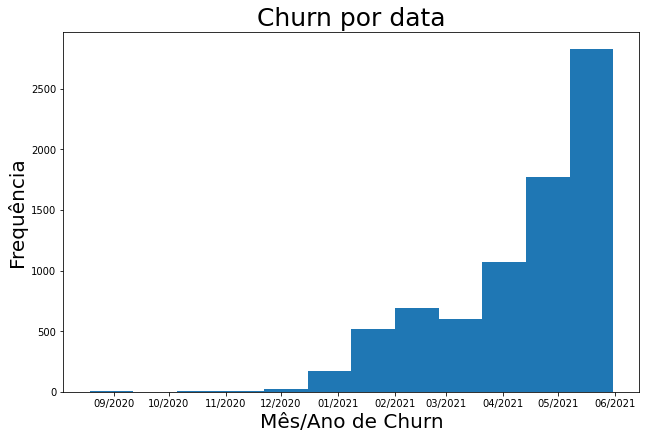

In [ ]:
formato_de_data = mdates.DateFormatter('%m/%Y')
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
plt.hist(ultimo_acesso_churn['ULTIMO_ACESSO'], bins=12)
eixo.set_title('Churn por data', fontsize=25)
eixo.set_ylabel('Frequência', fontsize=20)
eixo.set_xlabel('Mês/Ano de Churn', fontsize=20)
eixo.xaxis.set_major_formatter(formato_de_data)
plt.show()

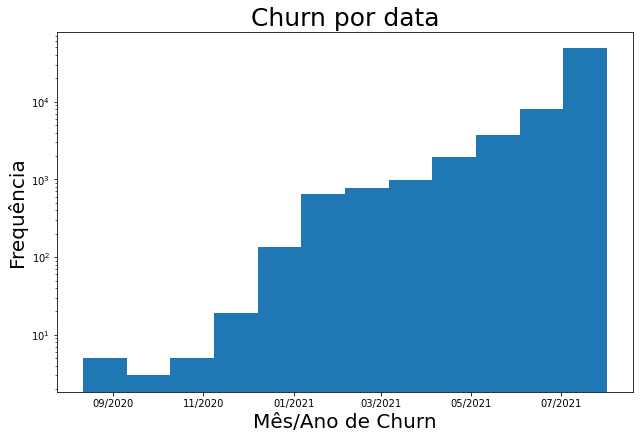

In [ ]:
formato_de_data = mdates.DateFormatter('%m/%Y')
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
plt.hist(ultimo_acesso['ULTIMO_ACESSO'], bins=12)
eixo.set_title('Churn por data', fontsize=25)
eixo.set_ylabel('Frequência', fontsize=20)
eixo.set_xlabel('Mês/Ano de Churn', fontsize=20)
eixo.xaxis.set_major_formatter(formato_de_data)
plt.yscale('log')
plt.show()

Observamos que a quantidade de usuários que são churns, por data, crescem a medida que o tempo avança

**Será que não observamos este notável crescimento por viéses na base de dados?**

Será que a grande concentração de dados entre 03/2021 - 07/2021 não dificulta nossa análise?

### Tarefa 5: Analisar frequência geográfica x Churn (qual cidade tem mais churn, etc)

# Profiles

## Importanto pasta com profiles:

In [ ]:
# caminho do drive para pasta com profiles
caminho_profiles = '/content/drive/MyDrive/Dados Next/profiles.parquet'
file_profiles = dd.read_parquet(caminho_profiles+"/*.parquet")

In [ ]:
file_profiles.columns

Index(['app_user_id', 'creation_at', 'last_data_session', 'last_event_at',
       'last_summarized_data', 'operating_system', 'registered_at',
       'applications_id_list', 'user_segments_id_list', 'points_of_interest',
       'latitude', 'longitude', 'state', 'city', 'census_code',
       'advertising_id', 'created_at', 'installation_number_list',
       'token_push_generated_at', 'token_push_notification',
       'window_active_days_count', 'user_frequency', 'last_handset',
       'last_network_operator', 'last_sim_card', 'trusted_handsets',
       'trusted_network_operators', 'trusted_sim_cards', 'trusted_wireless',
       'job_customer', 'job_host_app', 'job_reference_date', 'job_created_at'],
      dtype='object')

## Significado de cada Coluna:


* app_user_id	= Identificador do usuário gerado a partir de uma combinação única de host_app_package, advertiding_id e external_id
* ***creation_at***	= Data de criação do ID de usuário
* ***last_data_session***	=	Data do último evento Data Session enviado
* ***last_event_at***	9/15/2021		Date	Data do último evento enviado
* last_summarized_data	9/15/2021		Date	Data do último evento Summarized Data enviado
* operating_system =	Sistema operacional (ANDROID ou iOS)
* ***registered_at***	=	Data de registro
* applications_id_list	=	Lista de IDs de todos os aplicativos (Android) ou a lista de aplicativos definida pelo cliente (iOS)
* user_segments_id_list	=	Lista de IDs de grupos de aplicativos
* points_of_interest = Contém a posição geográfica, código censitário, estado
e cidade de pontos de interesse identificados na execução do DBScan
* latitude	= Latitude do principal ponto de interesse
* longitude	= Longitude do principal ponto de interesse
* ***state***	= Estado do principal ponto de interesse
* ***city*** = Cidade do principal ponto de interesse
* census_code	= Código censitário do principal ponto de interesse
* advertising_id =	Código de Publicidade do Google/Apple
* ***created_at*** = Data e hora de criação do ID de usuário
* ***external_identifier*** = Campo utilizado pelo cliente para
identificação de
um usuário
* installation_number_list = Identificadores únicos Cinnecta gerados por incremento do banco de dados MySQL e associados ao app_user_id
* token_push_generated_at	= Data e hora de geração do token de push notification
* token_push_notification	=	Token do push
notification
recebido
***window_active_days_count***	= Quantidade de dias distintos o usuário envitou eventos dentro do intervalor de 90 dias
* ***user_frequency***= Categoria de frequência de uso
determinada pelo
K-Means
* data_session_hourly	= Mapeamento da quantidade de data sessions por hora do dia
* last_handset = Último modelo de celular utilizado
* last_network_operator =	Última operadora de celular utilizada
* last_sim_card	=	ICCID do último cartão SIM utilizado
* trusted_handsets = Modelos de celulares utilizados em pelo menos 3 dos últimos 6 dias
* trusted_network_operators = Operadoras utilizadas em pelo menos 3 dos últimos 6 dias
* trusted_sim_cards = ICCIDs dos cartões SIM utilizados em pelo menos 3 dos últimos 6 dias
* trusted_wireless = Conexões sem fio usadas em pelo menos 3 dos últimos 6 dias
* job_customer	= Identificador do cliente
* job_host_app =	Integer	Identificador do host app
* job_reference_date	=	Data dos arquivos processados pelo job
* job_created_at	=	Data e hora real que o job foi executado

##Colunas retiradas file_profiles_drop
- app_user_id
- creation_at
- operating_system
- registered_at
- applications_id_list
- user_segments_id_list
- points_of_interest
- latitude
- longitude
- census_code
- advertising_id
- created_at
- external_identifier 
- installation_number_list
- token_push_generated_at
- token_push_notification


 

##Colunas Relevantes 


 ***last_data_session*** =	Data do último evento Data Session enviado
* ***last_event_at***	9/15/2021		Date	Data do último evento enviado
* ***last_summarized_data***	9/15/2021		Date	Data do último evento Summarized Data enviado
* ***state***	= Estado do principal ponto de interesse
* ***city*** = Cidade do principal ponto de interesse
* ***installation_number_list*** = Identificadores únicos Cinnecta gerados por incremento do banco de dados MySQL e associados ao app_user_id ***duvida***
* ***token_push_generated_at***	= Data e hora de geração do token de push notification
* ***token_push_notification***	=	Token do push notification recebido
***window_active_days_count***	= Quantidade de dias distintos o usuário envitou eventos dentro do intervalor de 90 dias
* ***user_frequency***= Categoria de frequência de uso
determinada pelo K-Means
* ***data_session_hourly***	= Mapeamento da quantidade de data sessions por hora do dia
* ***last_handset*** = Último modelo de celular utilizado
* ***last_network_operator*** =	Última operadora de celular utilizada
* ***last_sim_card***	=	ICCID do último cartão SIM utilizado
* ***trusted_handsets*** = Modelos de celulares utilizados em pelo menos 3 dos últimos 6 dias
* ***trusted_network_operators*** = Operadoras utilizadas em pelo menos 3 dos últimos 6 dias
* ***trusted_sim_cards*** = ICCIDs dos cartões SIM utilizados em pelo menos 3 dos últimos 6 dias
* ***trusted_wireless*** = Conexões sem fio usadas em pelo menos 3 dos últimos 6 dias
* ***job_customer***	= Identificador do cliente
* ***job_host_app*** =	Integer	Identificador do host app
* ***job_reference_date***	=	Data dos arquivos processados pelo job
* ***job_created_at***	=	Data e hora real que o job foi executado

* Transformando tipo datetime em numeros

In [ ]:
file_profiles = file_profiles.compute()

In [ ]:
for nome_coluna in file_profiles.columns:
  if(  "datetime" in str(file_profiles[nome_coluna].dtype) ):
    file_profiles[nome_coluna] = ((pd.to_datetime(file_profiles[nome_coluna])- pd.to_datetime("2021/07/30")).map(lambda x: x.days))

    print(nome_coluna)

created_at
token_push_generated_at


In [ ]:
for nome_coluna in file_profiles.columns:
  coluna_tipo = file_profiles[nome_coluna].dtype
  print(str(nome_coluna)+" - "+str(coluna_tipo))

app_user_id - Int64
creation_at - object
last_data_session - object
last_event_at - object
last_summarized_data - object
operating_system - string
registered_at - object
applications_id_list - object
user_segments_id_list - object
points_of_interest - string
latitude - float32
longitude - float32
state - string
city - string
census_code - string
advertising_id - string
created_at - int64
installation_number_list - object
token_push_generated_at - float64
token_push_notification - string
window_active_days_count - Int32
user_frequency - string
last_handset - string
last_network_operator - string
last_sim_card - string
trusted_handsets - string
trusted_network_operators - string
trusted_sim_cards - string
trusted_wireless - string
job_customer - Int32
job_host_app - Int32
job_reference_date - string
job_created_at - string


In [ ]:
#for coluna in file_profiles.columns:  #descomentar
if (1==1):#comentar
  coluna='last_network_operator'#comentar
  categorias = file_profiles[coluna] 
  print(len(categorias))
  categorias=list(set(categorias))
  print(len(categorias))
  print(categorias[0])

  def getCategoria(item):
    for i in range(len(categorias)):
      if(item==categorias[i]):
        return i
  print(list(map(getCategoria,file_profiles[coluna] )))#comentar
  #file_profiles[coluna] = (list(map(getCategoria,file_profiles[coluna] )))#descomentar


***Label Encoder***
* Se tomarmos como exemplo os países: Brasil/EUA/Japão (que foram convertidos em 0/1/2) o modelo poderá se confundir ao achar que as datas representam algum tipo de ordem: 0 < 1 < 2 e atribuir um peso maior ao Japão por exemplo.
***One-hot Encoder**
*  desvantagem desse método comparado ao anterior é que, se tivermos muitas categorias para uma variável, iremos produzir muitas colunas adicionais e dependendo do modelo que estamos utilizando, podemos introduzir outros problemas de desempenho.
***Conclusao***
* Uso do One-Hot e o melhor em casos de poucas tabelas e sera usado quando nao for usado o label encoder pois em no label como falado a cima pelo seu metodo de separaçao pode ser confundido como uma ordem de maioridade e o One-Hot ja nao tem esse problema assim podendo se sair melhor na separaçao das tabelas 
mas dependendo do tamanho pode se peder o desempenho 

In [ ]:
caminho  = '/content/drive/My Drive/Dados Next/' #acessando o caminho do drive 

In [ ]:
dados = pd.read_parquet(caminho + 'base_numeral_categorias.parquet')#aplicando caminho a variavel dados e acessando a base numeral na pasta next

In [ ]:
dados.head()#lendo dados

,index,EXTERNAL_IDENTIFIER,QT_DIAS_ACESSADOS,QT_MESES_ACESSO,DURATION_TOTAL,DURATION_MAX,DURATION_MIN,CAT_CHURN,QT_ACESSOS,user_frequency,DIAS_ULTIMO_ACESSO
0,0.0,++2OlFA8+GV6Ni9cvdGXGJtgW98rZO0BA2OwmMdbROBHOw...,77.0,3.0,1155.0,276.0,32.0,FREQUENTE,32.0,FREQUENT,26.0
1,1.0,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,47.0,2.0,328.0,73.0,32.0,CERTEZA_CHURN,1.0,INFREQUENT,32.0
2,2.0,++4s1WdfVHGtQTSaAIhvfS1IpnAaSfwBffh+GFQxaDFAPM...,170.0,5.0,1019.0,317.0,42.0,FREQUENTE,23.0,FREQUENT,26.0
3,3.0,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,28.0,2.0,548.0,67.0,33.0,FREQUENTE,NaN,None,NaN
4,4.0,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,27.0,1.0,1068.0,257.0,34.0,FREQUENTE,NaN,None,NaN


In [ ]:
Y = pd.get_dummies(dados.CAT_CHURN) # transformando a coluna cat churn em onehot 

In [ ]:
Y.head()#lendo a variavel Y que esta com a funçao de transformar  

,CERTEZA_CHURN,TALVEZ_CHURN,INFREQUENTE,FREQUENTE
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [ ]:
onehotencoder = pd.concat([dados, Y], axis = 1) #concatenando 

In [ ]:
onehotencoder

,index,EXTERNAL_IDENTIFIER,QT_DIAS_ACESSADOS,QT_MESES_ACESSO,DURATION_TOTAL,DURATION_MAX,DURATION_MIN,CAT_CHURN,QT_ACESSOS,user_frequency,DIAS_ULTIMO_ACESSO,CERTEZA_CHURN,TALVEZ_CHURN,INFREQUENTE,FREQUENTE
0,0.0,++2OlFA8+GV6Ni9cvdGXGJtgW98rZO0BA2OwmMdbROBHOw...,77.0,3.0,1155.0,276.0,32.0,FREQUENTE,32.0,FREQUENT,26.0,0,0,0,1
1,1.0,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,47.0,2.0,328.0,73.0,32.0,CERTEZA_CHURN,1.0,INFREQUENT,32.0,1,0,0,0
2,2.0,++4s1WdfVHGtQTSaAIhvfS1IpnAaSfwBffh+GFQxaDFAPM...,170.0,5.0,1019.0,317.0,42.0,FREQUENTE,23.0,FREQUENT,26.0,0,0,0,1
3,3.0,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,28.0,2.0,548.0,67.0,33.0,FREQUENTE,NaN,None,NaN,0,0,0,1
4,4.0,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,27.0,1.0,1068.0,257.0,34.0,FREQUENTE,NaN,None,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68470,NaN,tQi2sxRqsSJGG8XfBnHXpMEJ0m7w5balHVvXGUtzJsXnkc...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,INFREQUENT,108.0,0,0,0,0
68471,NaN,ud3tRBr4uTG+yTYH+AfXoe8OgYVLt9zvE4AFLTwETHqL/V...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,INFREQUENT,60.0,0,0,0,0
68472,NaN,vLvIn+q12pMxGfUQ4fVmTRHjBY++IipfyogjljglbqbkYH...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,228.0,0,0,0,0
68473,NaN,yMXV+8dZNAXM9WrmgM5IC5xqeE4+YgLsoUcAbQ2E/3d9PF...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,INFREQUENT,66.0,0,0,0,0


In [ ]:
#Retirando a coluna Cat_churn pq ja estava tranformada em onehorencoder
colunas  = ["CAT_CHURN",]
onehotencoder = onehotencoder.copy()
for coluna in colunas:
  onehotencoder = onehotencoder.drop(coluna, axis= 1) 

In [ ]:
onehotencoder

,CERTEZA_CHURN,DIAS_ULTIMO_ACESSO,DURATION_MAX,DURATION_MIN,DURATION_TOTAL,EXTERNAL_IDENTIFIER,FREQUENTE,INFREQUENTE,QT_ACESSOS,QT_DIAS_ACESSADOS,QT_MESES_ACESSO,TALVEZ_CHURN,index,user_frequency
0,NaN,26.0,276.0,32.0,1155.0,++2OlFA8+GV6Ni9cvdGXGJtgW98rZO0BA2OwmMdbROBHOw...,NaN,NaN,32.0,77.0,3.0,NaN,0.0,FREQUENT
1,NaN,32.0,73.0,32.0,328.0,++3etc7PcO7zNRlRZjptqC63K0h+CxTJEu/khqOXex+EA2...,NaN,NaN,1.0,47.0,2.0,NaN,1.0,INFREQUENT
2,NaN,26.0,317.0,42.0,1019.0,++4s1WdfVHGtQTSaAIhvfS1IpnAaSfwBffh+GFQxaDFAPM...,NaN,NaN,23.0,170.0,5.0,NaN,2.0,FREQUENT
3,NaN,NaN,67.0,33.0,548.0,++6Gg3renAwWeEYBj9ZcTtkerRSYuyRyOBJ9uwv76phQYa...,NaN,NaN,NaN,28.0,2.0,NaN,3.0,None
4,NaN,NaN,257.0,34.0,1068.0,++CeDrL1oBwb9P+WL82ZFfLXAnnenzRavVVscx2Xwnzos3...,NaN,NaN,NaN,27.0,1.0,NaN,4.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68470,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
68471,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
68472,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
68473,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [ ]:
#atributos numericos
pandas.qcut 
pandas.cut


In [ ]:
file_profiles.head()

,app_user_id,creation_at,last_data_session,last_event_at,last_summarized_data,operating_system,registered_at,applications_id_list,user_segments_id_list,points_of_interest,...,last_network_operator,last_sim_card,trusted_handsets,trusted_network_operators,trusted_sim_cards,trusted_wireless,job_customer,job_host_app,job_reference_date,job_created_at
external_identifier,,,,,,,,,,,,,,,,,,,,,
+1+0Ot0T9FrMR8YeDabzop78uFwadzaD29KF5mRbKUgROkO6EOLvCR1M6d9ytexT,28255592,2020-05-27,2021-07-29,2021-07-30,2021-07-30,ANDROID,2020-05-27,"[86, 334]",[],"[{""type"": ""home"", ""latitude"": -24.725362777709...",...,"{""network_operator"": ""Vivo""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(8)"", ""installati...","[{""network_operator"": ""Vivo""}, {""network_opera...",[],"[{""ssid"": ""Leliane"", ""bssid"": ""78:17:35:87:3e:...",42,963,2021-07-30,2021-07-31T02:45:57.042975
+BV582wTZqZu2AzE0jOO1hfs8EVs3wamqfe+54lWNiCNsGeiMSg8QjXeU+93Ud4N,29814434,2020-05-31,2021-07-30,2021-07-30,2021-07-29,ANDROID,2020-06-08,"[5503, 39812, 82, 74, 40190, 5556, 26, 39625, ...","[179, 212, 180, 208, 223, 225, 178]","[{""type"": ""home"", ""latitude"": -12.835678100585...",...,"{""network_operator"": ""72402""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""Xiaomi:Redmi Note 8 Pro"", ""insta...","[{""network_operator"": ""72402""}, {""network_oper...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+FzKIRuFARUFSBW3QuLRtwFv/g39KXeMGpkv4DO7qP8bEkbgrctrmOA1ZGnaUbCW,46389103,2020-11-02,2021-07-30,2021-07-30,2021-07-25,ANDROID,2020-11-02,"[74, 39624, 106, 5348, 6407, 39627, 304, 24382...","[180, 208, 209, 178]","[{""type"": ""home"", ""latitude"": -23.582885742187...",...,"{""network_operator"": ""72403""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""samsung:SM-A013M"", ""installation...","[{""network_operator"": ""TIMBRASIL""}, {""network_...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+G1aRZe5CLXmNPNYjhIQpxMvo9Dzo1Zx/W6/0FtOboAvp3ao9Kq3pL0sPObIb8WW,47332576,2020-11-13,2021-07-29,2021-07-29,2021-07-29,ANDROID,2020-11-13,"[82, 74, 6798, 106, 24468, 26, 40540, 29556, 1...","[215, 179, 212, 180, 208, 209, 178, 226]",<NA>,...,"{""network_operator"": ""Claro BR""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(6) play"", ""insta...","[{""network_operator"": ""Claro BR""}]",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+OTf767udtoBUMqjR0rtlxgyMXLSk7l6LJTUtsrElb4bB6cxFU3jX2Fgx9qRbJYj,50631149,2020-12-13,2021-01-13,2021-02-04,2021-02-04,ANDROID,2020-12-13,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42,963,2021-07-30,2021-07-31T02:45:57.042975


pesquisar sobre
labelencoder  
onehot

* 3 - apagar colunas original e colocar a nova 


In [ ]:
colunas  = ['app_user_id',
'creation_at',
'operating_system',
'registered_at',
'applications_id_list',
'user_segments_id_list',
'points_of_interest',
'latitude',
'longitude',
'census_code',
'advertising_id',
'created_at',
'installation_number_list',
'token_push_generated_at',
'token_push_notification',]
file_profiles_drop = file_profiles.copy()
for coluna in colunas:
  file_profiles_drop = file_profiles_drop.drop(coluna, axis= 1) 

In [ ]:
file_profiles_drop.head()

,last_data_session,last_event_at,last_summarized_data,state,city,window_active_days_count,user_frequency,last_handset,last_network_operator,last_sim_card,trusted_handsets,trusted_network_operators,trusted_sim_cards,trusted_wireless,job_customer,job_host_app,job_reference_date,job_created_at
external_identifier,,,,,,,,,,,,,,,,,,
+1+0Ot0T9FrMR8YeDabzop78uFwadzaD29KF5mRbKUgROkO6EOLvCR1M6d9ytexT,2021-07-29,2021-07-30,2021-07-30,SP,CAJATI,47,FREQUENT,"{""handset"": ""motorola:moto g(8)"", ""installatio...","{""network_operator"": ""Vivo""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(8)"", ""installati...","[{""network_operator"": ""Vivo""}, {""network_opera...",[],"[{""ssid"": ""Leliane"", ""bssid"": ""78:17:35:87:3e:...",42,963,2021-07-30,2021-07-31T02:45:57.042975
+BV582wTZqZu2AzE0jOO1hfs8EVs3wamqfe+54lWNiCNsGeiMSg8QjXeU+93Ud4N,2021-07-30,2021-07-30,2021-07-29,BA,SALVADOR,36,FREQUENT,"{""handset"": ""Xiaomi:Redmi Note 8 Pro"", ""instal...","{""network_operator"": ""72402""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""Xiaomi:Redmi Note 8 Pro"", ""insta...","[{""network_operator"": ""72402""}, {""network_oper...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+FzKIRuFARUFSBW3QuLRtwFv/g39KXeMGpkv4DO7qP8bEkbgrctrmOA1ZGnaUbCW,2021-07-30,2021-07-30,2021-07-25,SP,SÃO PAULO,57,FREQUENT,"{""handset"": ""samsung:SM-A013M"", ""installation_...","{""network_operator"": ""72403""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""samsung:SM-A013M"", ""installation...","[{""network_operator"": ""TIMBRASIL""}, {""network_...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+G1aRZe5CLXmNPNYjhIQpxMvo9Dzo1Zx/W6/0FtOboAvp3ao9Kq3pL0sPObIb8WW,2021-07-29,2021-07-29,2021-07-29,<NA>,<NA>,29,MODERATE,"{""handset"": ""motorola:moto g(6) play"", ""instal...","{""network_operator"": ""Claro BR""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(6) play"", ""insta...","[{""network_operator"": ""Claro BR""}]",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+OTf767udtoBUMqjR0rtlxgyMXLSk7l6LJTUtsrElb4bB6cxFU3jX2Fgx9qRbJYj,2021-01-13,2021-02-04,2021-02-04,<NA>,<NA>,0,INFREQUENT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42,963,2021-07-30,2021-07-31T02:45:57.042975


In [ ]:
file_profiles.head()

,app_user_id,creation_at,last_data_session,last_event_at,last_summarized_data,operating_system,registered_at,applications_id_list,user_segments_id_list,points_of_interest,...,last_network_operator,last_sim_card,trusted_handsets,trusted_network_operators,trusted_sim_cards,trusted_wireless,job_customer,job_host_app,job_reference_date,job_created_at
external_identifier,,,,,,,,,,,,,,,,,,,,,
+1+0Ot0T9FrMR8YeDabzop78uFwadzaD29KF5mRbKUgROkO6EOLvCR1M6d9ytexT,28255592,2020-05-27,2021-07-29,2021-07-30,2021-07-30,ANDROID,2020-05-27,"[86, 334]",[],"[{""type"": ""home"", ""latitude"": -24.725362777709...",...,"{""network_operator"": ""Vivo""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(8)"", ""installati...","[{""network_operator"": ""Vivo""}, {""network_opera...",[],"[{""ssid"": ""Leliane"", ""bssid"": ""78:17:35:87:3e:...",42,963,2021-07-30,2021-07-31T02:45:57.042975
+BV582wTZqZu2AzE0jOO1hfs8EVs3wamqfe+54lWNiCNsGeiMSg8QjXeU+93Ud4N,29814434,2020-05-31,2021-07-30,2021-07-30,2021-07-29,ANDROID,2020-06-08,"[5503, 39812, 82, 74, 40190, 5556, 26, 39625, ...","[179, 212, 180, 208, 223, 225, 178]","[{""type"": ""home"", ""latitude"": -12.835678100585...",...,"{""network_operator"": ""72402""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""Xiaomi:Redmi Note 8 Pro"", ""insta...","[{""network_operator"": ""72402""}, {""network_oper...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+FzKIRuFARUFSBW3QuLRtwFv/g39KXeMGpkv4DO7qP8bEkbgrctrmOA1ZGnaUbCW,46389103,2020-11-02,2021-07-30,2021-07-30,2021-07-25,ANDROID,2020-11-02,"[74, 39624, 106, 5348, 6407, 39627, 304, 24382...","[180, 208, 209, 178]","[{""type"": ""home"", ""latitude"": -23.582885742187...",...,"{""network_operator"": ""72403""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""samsung:SM-A013M"", ""installation...","[{""network_operator"": ""TIMBRASIL""}, {""network_...",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+G1aRZe5CLXmNPNYjhIQpxMvo9Dzo1Zx/W6/0FtOboAvp3ao9Kq3pL0sPObIb8WW,47332576,2020-11-13,2021-07-29,2021-07-29,2021-07-29,ANDROID,2020-11-13,"[82, 74, 6798, 106, 24468, 26, 40540, 29556, 1...","[215, 179, 212, 180, 208, 209, 178, 226]",<NA>,...,"{""network_operator"": ""Claro BR""}","{""iccid"": ""UNKNOWN""}","[{""handset"": ""motorola:moto g(6) play"", ""insta...","[{""network_operator"": ""Claro BR""}]",[],[],42,963,2021-07-30,2021-07-31T02:45:57.042975
+OTf767udtoBUMqjR0rtlxgyMXLSk7l6LJTUtsrElb4bB6cxFU3jX2Fgx9qRbJYj,50631149,2020-12-13,2021-01-13,2021-02-04,2021-02-04,ANDROID,2020-12-13,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42,963,2021-07-30,2021-07-31T02:45:57.042975
